<a href="https://colab.research.google.com/github/jaidatta71/ML---Berkeley/blob/main/mod_11_car_regression_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


!pip install category_encoders
import category_encoders as ce

import numpy as np
import plotly.express as px
import pandas as pd
import warnings

## 2. Load the Data

In [93]:
sales = pd.read_csv('/content/drive/MyDrive/practical_application_II_starter/data/vehicles.csv')

In [94]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

## 3. Data Clean up:
### Drop records if all the values are Null, Only ststus = Clean, Non Salved Cars, Keep data from year: 2000 only, Keep only Non Zero Priced cars


In [95]:
sales.dropna(subset = ['year',	'manufacturer',	'model',	'condition','cylinders',	'fuel',	'odometer',	'title_status',	'transmission',	'VIN',	'drive',	'size',	'type'])
sales = sales.dropna(subset = ['odometer','VIN'])
sales.isnull().sum().sort_values()

# keep on CLEAN title cars

sales.title_status.value_counts()                      # 405117
sales = sales.loc[sales["title_status"] == 'clean']    #  Keep only Clean status
sales  = sales[sales["condition"] != 'salvage']        #  Keep only NON SALVAGED cars  # 404892
sales  = sales[sales["year"] > 2000]                   #  Keep only sales after the year 2000. no.of records 345202
sales  = sales[sales["price"] >1 ]                     #  Keep only NON ZERO PRiced cars
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223136 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            223136 non-null  int64  
 1   region        223136 non-null  object 
 2   price         223136 non-null  int64  
 3   year          223136 non-null  float64
 4   manufacturer  217856 non-null  object 
 5   model         221957 non-null  object 
 6   condition     132499 non-null  object 
 7   cylinders     119789 non-null  object 
 8   fuel          221638 non-null  object 
 9   odometer      223136 non-null  float64
 10  title_status  223136 non-null  object 
 11  transmission  221706 non-null  object 
 12  VIN           223136 non-null  object 
 13  drive         163254 non-null  object 
 14  size          41527 non-null   object 
 15  type          200480 non-null  object 
 16  paint_color   172062 non-null  object 
 17  state         223136 non-null  object 
dtypes: float

## 4. Delete Duplicate VINs and keep only one record

In [96]:
#ss = sales[sales.duplicated('VIN')]
#ss.to_excel("/content/drive/MyDrive/practical_application_II_starter/data/sales.xlsx", index=False)

sales = sales.drop_duplicates(subset=['VIN'], keep='first')   # Delete Duplicate VINs and keep only one record

## 5. Drop VIN & ID

In [97]:
# Drop columns VIN & id columns
sales = sales.drop(["VIN","id"], axis=1)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95816 entries, 27 to 426746
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        95816 non-null  object 
 1   price         95816 non-null  int64  
 2   year          95816 non-null  float64
 3   manufacturer  93958 non-null  object 
 4   model         95366 non-null  object 
 5   condition     50297 non-null  object 
 6   cylinders     56688 non-null  object 
 7   fuel          94870 non-null  object 
 8   odometer      95816 non-null  float64
 9   title_status  95816 non-null  object 
 10  transmission  95095 non-null  object 
 11  drive         75042 non-null  object 
 12  size          24520 non-null  object 
 13  type          82954 non-null  object 
 14  paint_color   73937 non-null  object 
 15  state         95816 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 12.4+ MB


### 6. Add values to missing data for SIZE & TYPE. If type = truck, van, bus Update size = "full-size" etc..

In [98]:
sales.loc[sales['condition'].isnull()]
sales['condition'] = sales['condition'].fillna(sales['condition'].mode()[0])
sales.loc[sales['condition'].isnull()]
#sales[sales.isnull().any(axis=1)]

#   Add values to missing data for SIZE & TYPE. If type = truck, van, bus update size = "full-size"
sales.loc[sales["type"].isin(["sedan", "hatchback"]), "size"] = "compact"
sales.loc[sales["type"].isin(["SUV"]), "size"]                = "mid-size"
sales.loc[(sales["type"].isin(["truck","van","bus"]))  & (sales["size"].isna()),
           "size"]                                            =  "full-size"

sales.loc[sales["type"].isin(["sedan", "hatchback", "coupe"]) &
          sales["drive"].isin(["4wd", "fwd", "rwd"]) &
          sales["cylinders"].isin(["3 cylinders", "4 cylinders","6 cylinders"]) , "size"] = "compact"

sales.loc[sales["type"].isin(["truck", "pickup", "van", "mini-van"]) &
          sales["drive"].isin(["4wd", "fwd", "rwd"]) &
          sales["cylinders"].isin(["10 cylinders", "12 cylinders","6 cylinders", "8 cylinders"]) , "size"] = "full-size"

#xx.to_excel("/content/drive/MyDrive/practical_application_II_starter/data/sales_null.xlsx", index=False)

In [99]:
### IMPUTE Null values except for MODEL
#  ~~~~~~~~~~~~   IMPUTER ~~~~~~~~~~~~~~~~~~ use in PIPELINE ~~~~~~~~~~~~~~~~~~~
# from sklearn.impute import SimpleImputer

#cat_imputer_low = SimpleImputer(strategy='most_frequent')
#for col in ['drive','transmission','size','condition','fuel']:
#  sales[[col]] = cat_imputer_low.fit_transform(sales[[col]])

#cat_imputer_high = SimpleImputer(strategy='constant', fill_value='MISSING')
#for col in ['cylinders','type','manufacturer','paint_color','model']:
#  sales[[col]] = cat_imputer_high.fit_transform(sales[[col]])

## 7. In MODEL column just keep first TWO words & cut the rest. Store in a new column "model_short". Keep top N models per MANUFACTURER; Rest group it under  "others".

In [100]:
sales["model_short"] = sales["model"].str.split().str[:1].str.join(" ")
sales[["model_short","model"]]

# Step 1: Get count of every model under each Make.
counts = sales.groupby(["manufacturer", "model_short"]).size().reset_index(name="count").sort_values(by="count", ascending=False)

# Step 2: Merge back to original dataframe. It creates a new column called "count"
sales = sales.merge(counts, on=["manufacturer", "model_short"], how="left")

# Step 3: Replace Model with "others" if count < 11
sales["model_short"] = sales.apply(lambda row: "others" if row["count"] < 11 else row["model_short"], axis=1)

sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95816 entries, 0 to 95815
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   region        95816 non-null  object 
 1   price         95816 non-null  int64  
 2   year          95816 non-null  float64
 3   manufacturer  93958 non-null  object 
 4   model         95366 non-null  object 
 5   condition     95816 non-null  object 
 6   cylinders     56688 non-null  object 
 7   fuel          94870 non-null  object 
 8   odometer      95816 non-null  float64
 9   title_status  95816 non-null  object 
 10  transmission  95095 non-null  object 
 11  drive         75042 non-null  object 
 12  size          68137 non-null  object 
 13  type          82954 non-null  object 
 14  paint_color   73937 non-null  object 
 15  state         95816 non-null  object 
 16  model_short   95366 non-null  object 
 17  count         93508 non-null  float64
dtypes: float64(3), int64(1), o

## 8. Add a new column "model_median_price" which is a median price value grouped by manufacturer & models under it

In [101]:
#Step 4: Drop helper column
median_price_by_model = sales.groupby(['manufacturer','model_short'])['price'].median().rename('model_med_price')
sales = sales.merge(median_price_by_model, on=["manufacturer", "model_short"], how='left')


In [102]:
sales = sales.drop(columns=["count"])

In [103]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95816 entries, 0 to 95815
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           95816 non-null  object 
 1   price            95816 non-null  int64  
 2   year             95816 non-null  float64
 3   manufacturer     93958 non-null  object 
 4   model            95366 non-null  object 
 5   condition        95816 non-null  object 
 6   cylinders        56688 non-null  object 
 7   fuel             94870 non-null  object 
 8   odometer         95816 non-null  float64
 9   title_status     95816 non-null  object 
 10  transmission     95095 non-null  object 
 11  drive            75042 non-null  object 
 12  size             68137 non-null  object 
 13  type             82954 non-null  object 
 14  paint_color      73937 non-null  object 
 15  state            95816 non-null  object 
 16  model_short      95366 non-null  object 
 17  model_med_pr

### 9. Feature engineering (high impact). Create new features that are easy for more meaningful for car business: like No.of years(age), Miles driven per year, Odometer Reading (price per mile)

### Treat outliers with LOG transformation.
### For "price" add a new column called "price_log" after transforming Log-transform of target

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95816 entries, 0 to 95815
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region           95816 non-null  object 
 1   price            95816 non-null  float64
 2   year             95816 non-null  float64
 3   manufacturer     93958 non-null  object 
 4   model            95366 non-null  object 
 5   condition        95816 non-null  object 
 6   cylinders        56688 non-null  object 
 7   fuel             94870 non-null  object 
 8   odometer         95816 non-null  float64
 9   title_status     95816 non-null  object 
 10  transmission     95095 non-null  object 
 11  drive            75042 non-null  object 
 12  size             68137 non-null  object 
 13  type             82954 non-null  object 
 14  paint_color      73937 non-null  object 
 15  state            95816 non-null  object 
 16  model_short      95366 non-null  object 
 17  model_med_pr

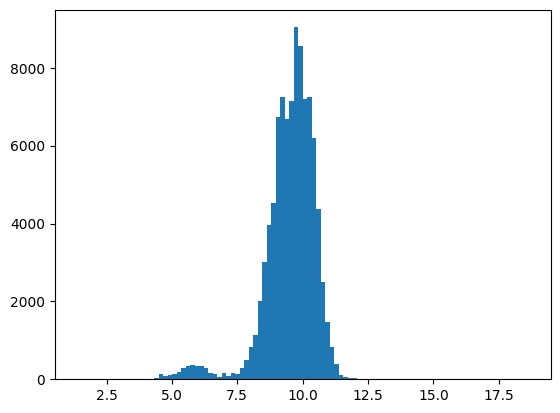

In [104]:

sales["age"] = 2025 - sales.year
sales["price_per_mile"] = sales["price"] / (sales["odometer"] + 1)
sales["miles_per_year"] = sales["odometer"] / (sales["age"] + 0.1)


################ Treat outliers of price with LOG transformation
sales['price'] = np.log1p(sales['price'])

#  Treat outliers of odometer, Age etc.,
sales['odometer']       = np.log1p(sales['odometer'])
sales['age']            = np.log1p(sales['age'])
sales['price_per_mile'] = np.log1p(sales['price_per_mile'])
sales['miles_per_year'] = np.log1p(sales['miles_per_year'])

plt.hist(sales['price'], bins=100)
sales.info()

sales  = sales.drop(["year"], axis=1)

### 10. Plots

<Figure size 1800x800 with 0 Axes>

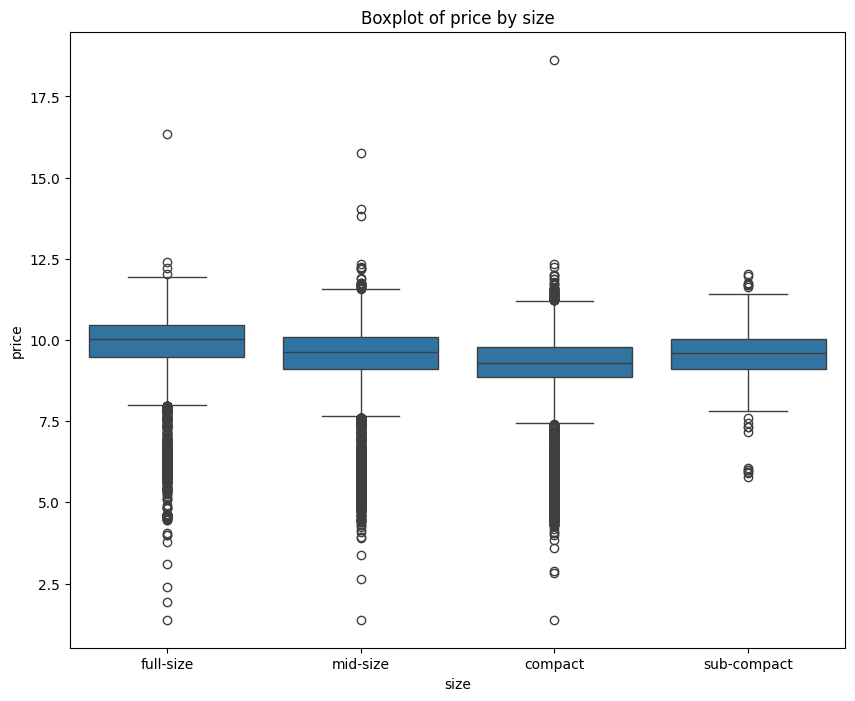

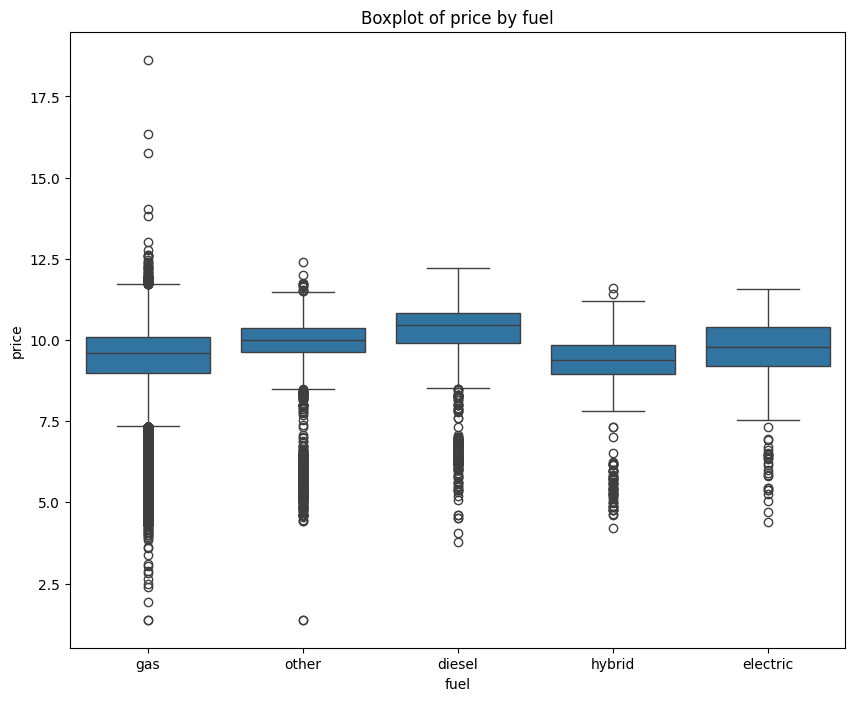

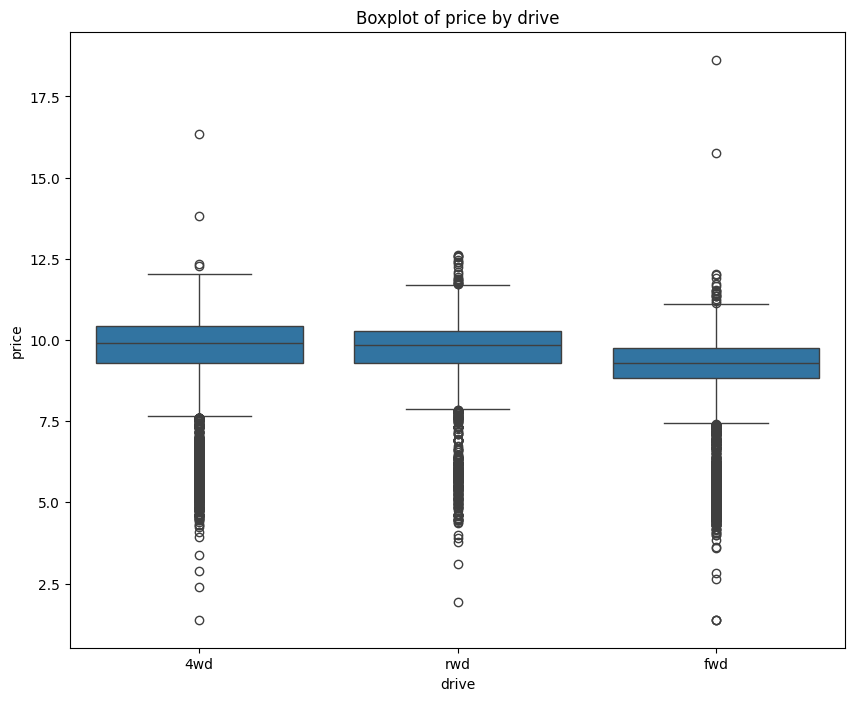

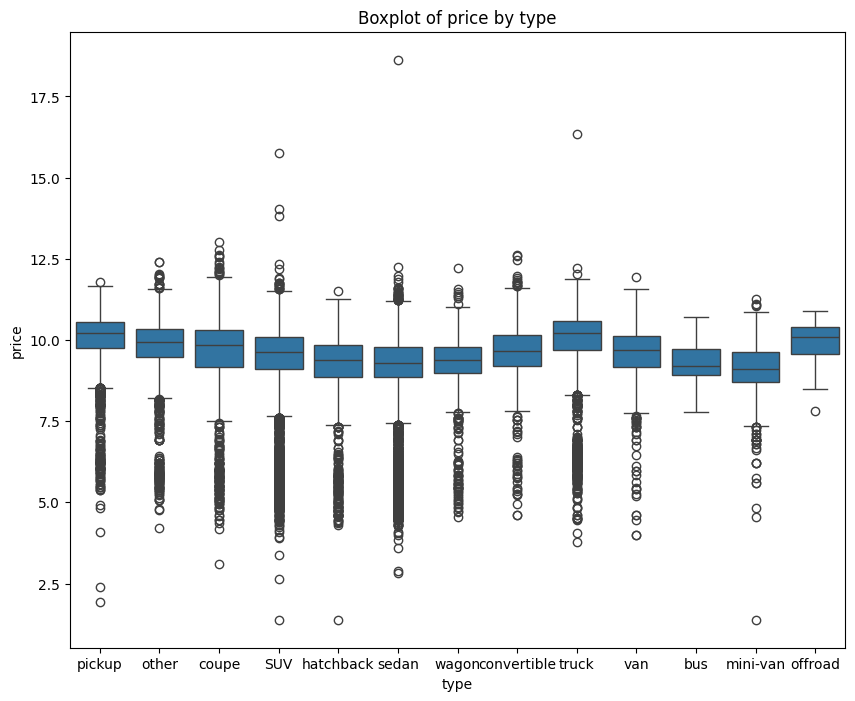

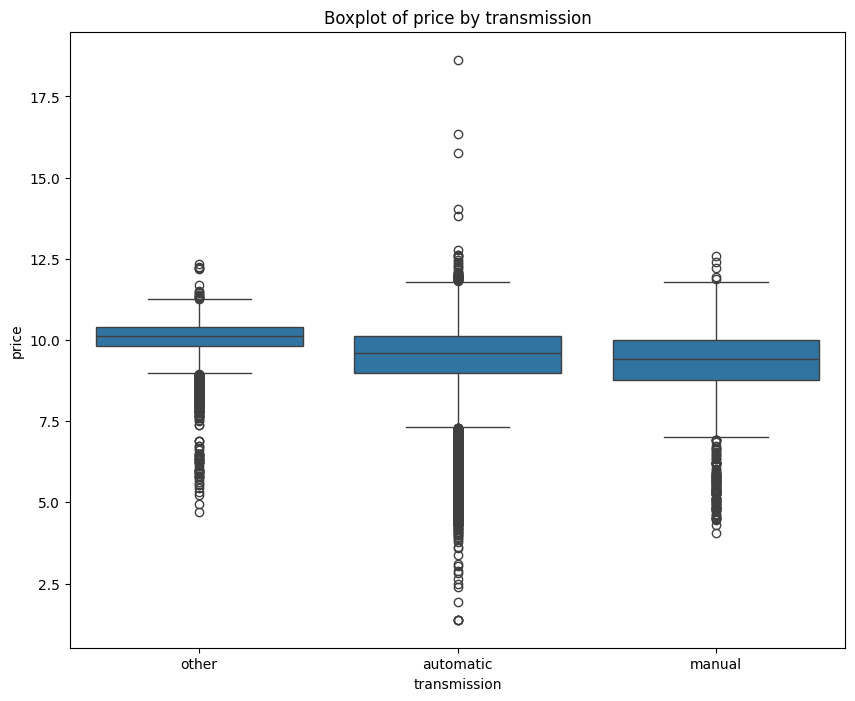

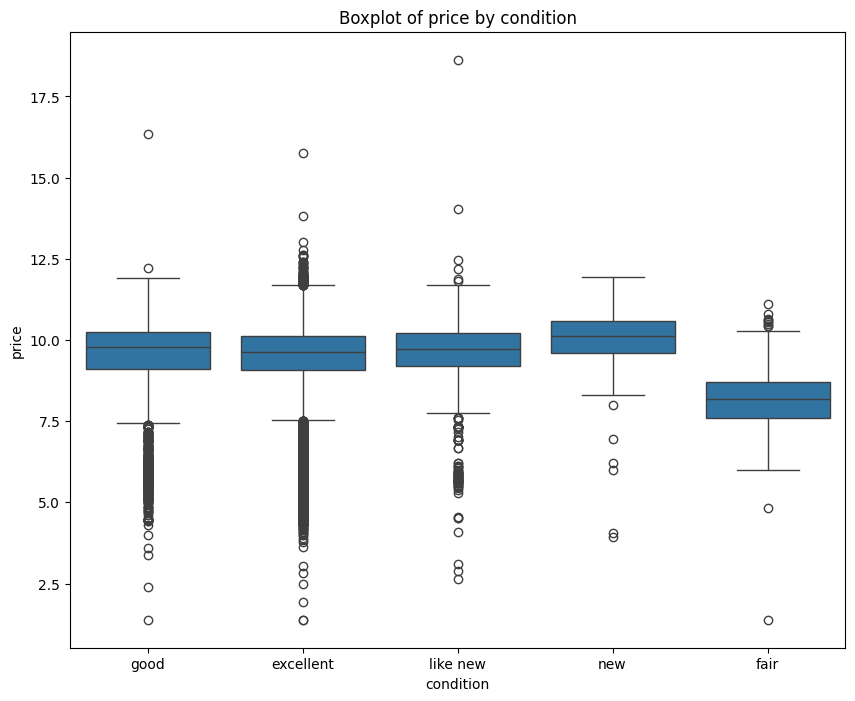

In [51]:
plt.figure(figsize=(18,8))
cat_cols = ["size", "fuel", "drive","type","transmission","condition"]

for col in cat_cols:
    plt.figure(figsize=(10,8))
    sns.boxplot(x=col, y="price", data=sales)
    plt.title(f"Boxplot of price by {col}")
    plt.show()

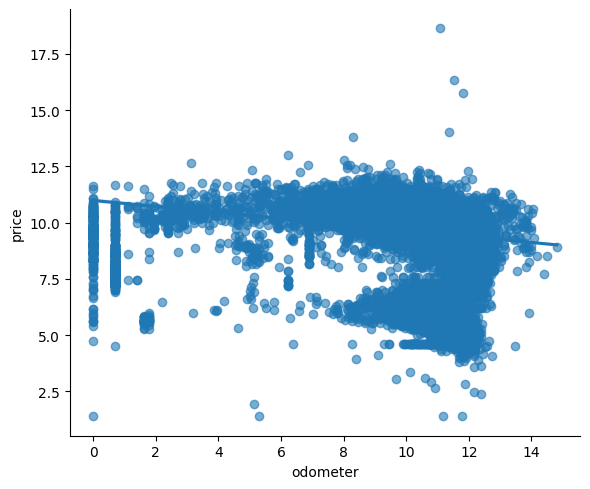

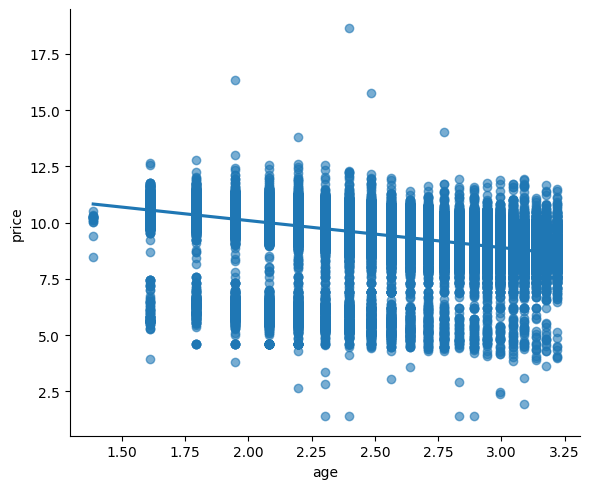

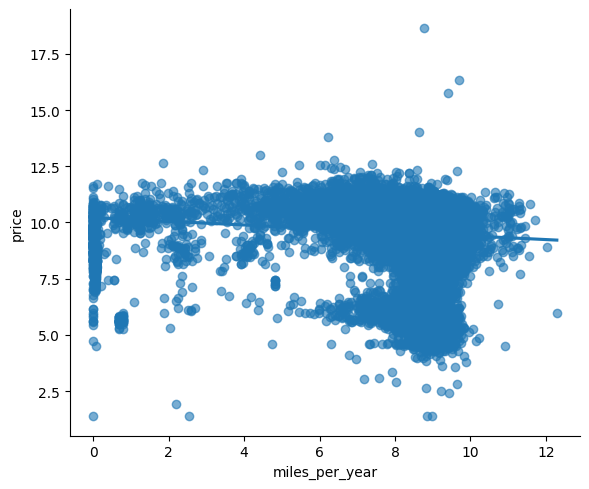

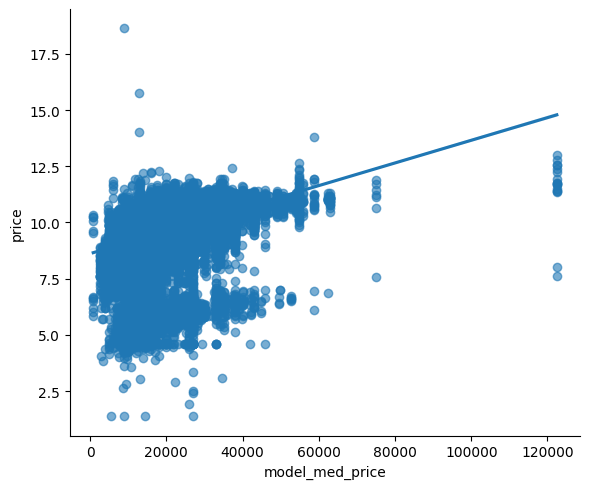

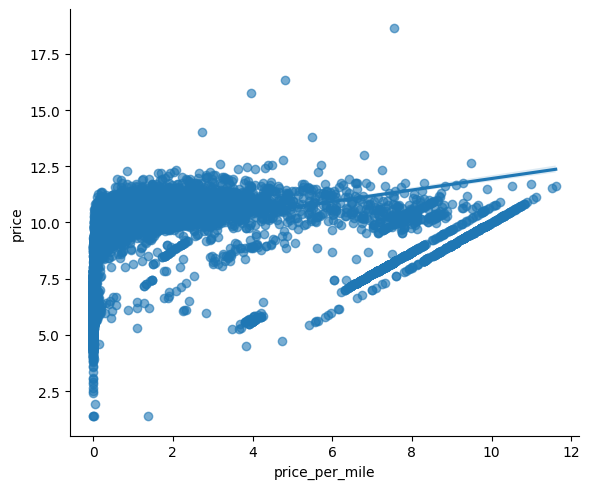

In [52]:
for col in ["odometer", "age", "miles_per_year","model_med_price","price_per_mile"]:
    sns.lmplot(x=col, y="price", data=sales, height=5, aspect=1.2, scatter_kws={"alpha":0.6})

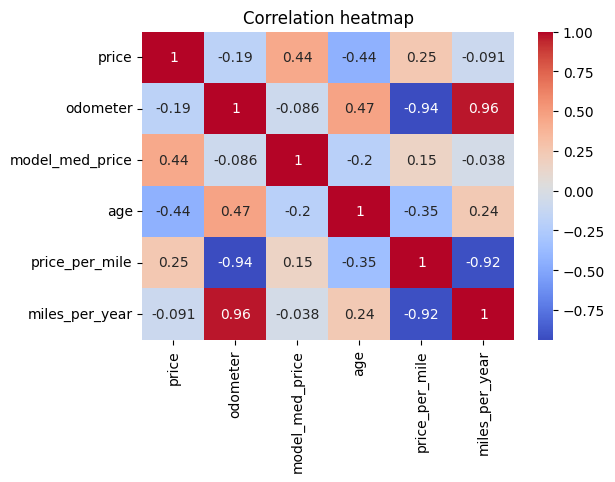

In [53]:
sales_numeric = sales.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(6, 4))
sns.heatmap(sales_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

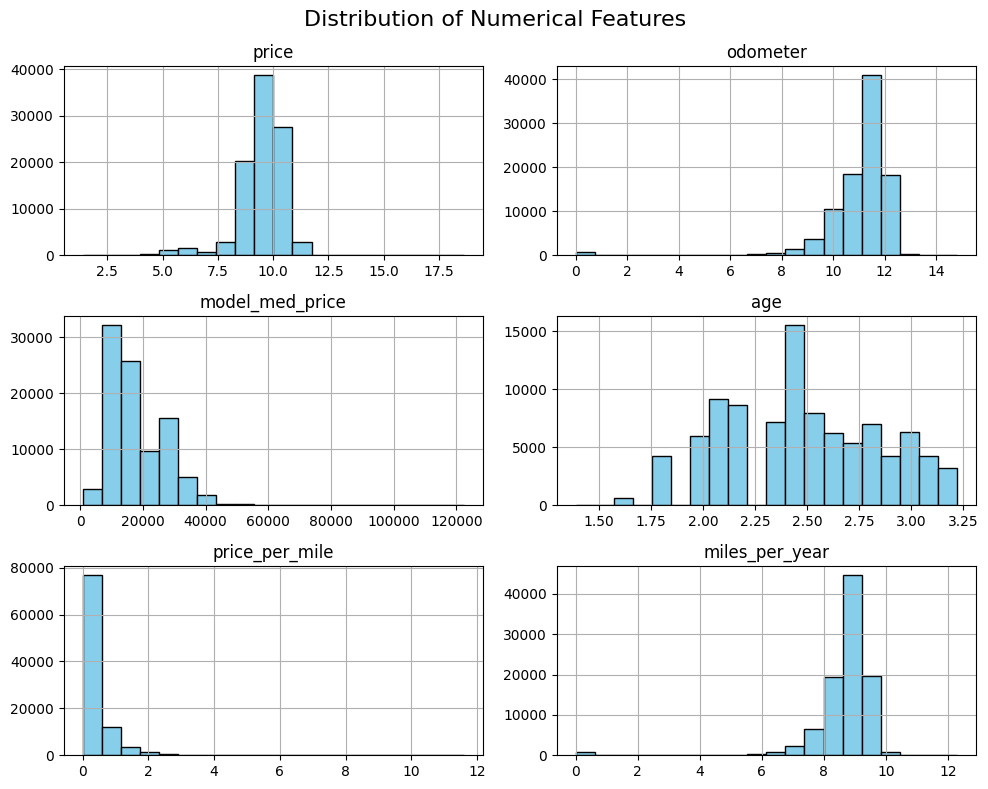

In [54]:
sales[sales_numeric.columns].hist(bins=20, figsize=(10, 8), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

### 11. Train/test SPLIT the Sales data

In [105]:
X = sales.drop(['price'], axis=1)
y = sales['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 12. PIPE Line construction
####  List Columns
####  Safe Target Encoding
####  Create ColumnTransformer
####  Preprocessing for numeric + low-cardinality categorical

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 67071, number of used features: 25
[LightGBM] [Info] Start training from score 2.347327


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Test RMSE: 0.07
Test MAE: 0.03
Test R²: 0.995


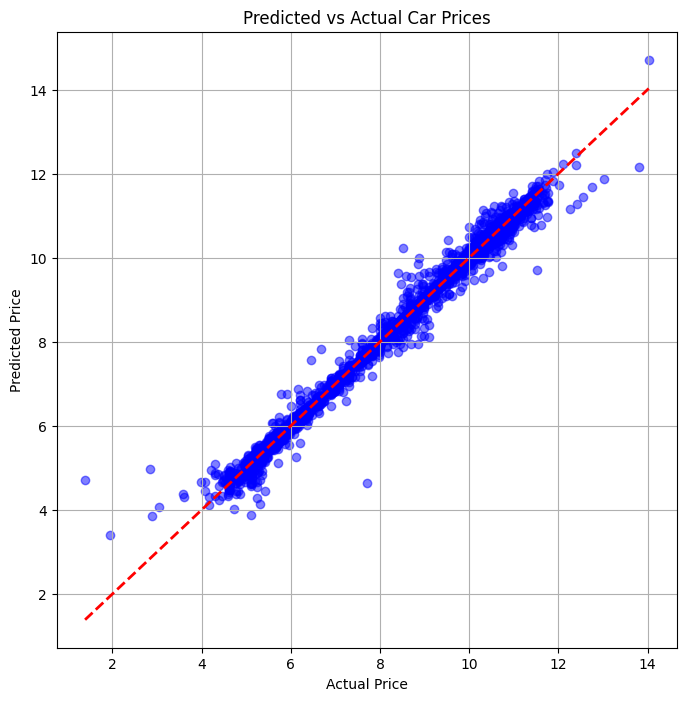

In [106]:
### Treat outliers of price with LOG transformation
sales['price'] = np.log1p(sales['price'])

X = sales.drop(['price'], axis=1)
y = sales['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



numeric_cols = ['odometer', 'age', 'model_med_price', 'price_per_mile','miles_per_year']
low_card_cols = ['fuel','size','condition', 'transmission', 'drive']
high_card_cols = ['manufacturer', 'model_short','cylinders','type']

# df['model_price_mean'] = df.groupby('model')['price'].transform('mean')

##  Safe Target Encoding

# Fit encoder on training set only
target_encoder = ce.TargetEncoder(cols=high_card_cols)
X_train_encoded = target_encoder.fit_transform(X_train, y_train)

# Transform test set using the fitted encoder
X_test_encoded = target_encoder.transform(X_test)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

low_card_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_cols),
    ('low_card', low_card_transformer, low_card_cols),
])


### Regression Model PIPE Line
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LGBMRegressor(
        n_estimators=1000, learning_rate=0.05, max_depth=-1, random_state=42, n_jobs=-1
    ))
])

#model = Pipeline(steps=[
#    ("preprocessor", preprocessor),
#    ("regressor", Lasso(alpha=0.01, random_state=42))
#])


### GridSearchCV for alpha

param_grid = {"regressor__alpha": [0.0001, 0.001, 0.01, 0.1, 1]}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model,
    param_grid,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_encoded, y_train)


### Predict and revert log-transform
y_pred_log = grid.best_estimator_.predict(X_test_encoded)

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

## Evaluate

mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.3f}")




import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5, color='blue')
plt.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.grid(True)
plt.show()
